In [0]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch
from torch import nn
from torch import optim

import math

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm as tqdm

In [0]:
from multiprocessing import Pool

In [33]:
# Для Colaboratory
# !rm utils.py
# !wget https://raw.githubusercontent.com/Intelligent-Systems-Phystech/model_selection/master/Grabovoy/practice/utils.py

In [0]:
##########################################
# https://github.com/mariogeiger/hessian #
##########################################
#                                        #
# Данные функции были взяты из интернета #
#                                        #
##########################################

from utils import gradient, jacobian, hessian

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Настройки Matplotlib

In [0]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = 36
plt.rcParams['ytick.labelsize'] = 36
plt.rcParams['legend.fontsize'] = 36
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=36
plt.rcParams['figure.figsize'] = (16.0, 8.0)
plt.rcParams['font.size'] = 24

# Эксперимент

В эксперименте была рассмотрена простая синтетическая выборка.
$$\mathbf{x} \sim \mathcal{N}\left(\textbf{0}, \mathbf{I}\right), \textbf{w} \sim \mathcal{N}\left(\textbf{0}, \mathbf{I}\right), y \sim \mathcal{N}\left(\textbf{w}^{\mathsf{T}}\textbf{x}, \beta\mathbf{I}\right)$$

In [0]:
m = 256
n = 25

w = np.random.randn(n)

X_train = np.random.randn(m, n)
Y_train = (X_train@w + 0.001*np.random.randn(m)).reshape([-1, 1])

X_test = np.random.randn(m, n)
Y_test = (X_test@w+ 0.001*np.random.randn(m)).reshape([-1, 1])

X_valid = np.random.randn(m, n)
Y_valid = (X_test@w+ 0.001*np.random.randn(m)).reshape([-1, 1])

In [0]:
train_data = TensorDataset(torch.Tensor(X_train).to(device), torch.Tensor(Y_train).to(device))
valid_data = TensorDataset(torch.Tensor(X_test).to(device), torch.Tensor(Y_test).to(device))
test_data = TensorDataset(torch.Tensor(X_test).to(device), torch.Tensor(Y_test).to(device))

In [0]:
X_ts, Y_ts = test_data[:]

X_tr, Y_tr = train_data[:]

X_valid, Y_valid = valid_data[:]

В качестве модели рассматривалась полносвязная нейросеть с разным количеством нейронов на скрытом слое.

In [0]:
class Neural(nn.Module):
    def __init__(self, input_dim=10, hidden_dim=3, output_dim=1, device='cpu'):
        """
        """
        super(Neural, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.device = device

        self.body = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.LeakyReLU(),
        )
        
        self.head = nn.Linear(self.hidden_dim, self.output_dim)
        
        list_of_h = []
        for w in self.parameters():
            list_of_h.append(torch.ones_like(w.data, requires_grad=True))
        
        self.list_of_h = list_of_h
        
        self.to(device)

        
    def predict(self, input):
        """
        Args:
            input: Tensor(batch_size x input_dim) --- the matrix of input data
            
        Returns:
            Tensor(batch_size x output_dim) --- the matrix of output data
        
        """
        out = input
        out = self.body(out)
        return self.head(out)
    
    def log_prior_w(self, w, h):
        """
        """
        w = w.view(-1)
        h = h.view(-1)
        return -0.5*torch.dot(w*(h**2), w)
      
    def log_priot_all(self):
        temp = 0
        i_temp = 0
        for w, h in zip(self.parameters(), self.list_of_h):
            temp += self.log_prior_w(w, h)
        return temp
     
    def loglikelihood(self, batch_x, batch_y):
        """
        """
        beta = 1
        return -0.5*beta*torch.mean((self.predict(batch_x) - batch_y)**2)
    
    def margin_log_likelihood(self, batch_x, batch_y):
        """
        """
        temp = self.log_priot_all() + self.loglikelihood(batch_x, batch_y)
        return temp
    
    def loss(self, batch_x, batch_y):
        out = self.predict(batch_x)
        return torch.mean((out - batch_y)**2)
    
    def random_h_init(self):
        for h in self.list_of_h:
            h.data = torch.rand_like(h.data)

    def h_zero_grad(self):
        for h in self.list_of_h:
            h.grad.zero_()

    def h_set_grad(self, grad):
        bias = 0
        for h in self.list_of_h:
            h_size = torch.tensor(h.size()).prod()
            h.grad = grad[bias:bias+h_size].view_as(h)
            bias+=h_size

# Random Search

In [0]:
def h_to_numpy(model):
    List_of_h = []
    for h in model.list_of_h:
        List_of_h.append(h.data.cpu().numpy().reshape(-1))

    return np.hstack(List_of_h)

def random_search(number_of_search = 10, progress = list):
    List_of_h = []
    List_of_loss = []

    for _ in progress(range(number_of_search)):
        model = Neural(input_dim=n, output_dim=1, hidden_dim=1)
        model.random_h_init()

        optimazer = optim.Adam(model.parameters(), lr=0.01)

        List_of_step = []

        for ep in range(200):
            generator = DataLoader(train_data, batch_size=64, shuffle=True)
            for batch_x, batch_y in generator:
                model.zero_grad()
                loss = -model.margin_log_likelihood(batch_x, batch_y)
                loss.backward()
                optimazer.step()

        List_of_h.append(h_to_numpy(model))
        List_of_loss.append(model.loss(X_valid, Y_valid).item())

    return np.array(List_of_h), np.array(List_of_loss)

In [36]:
%%time
List_of_h, List_of_loss = random_search(100, progress=tqdm)

100%|██████████| 100/100 [02:13<00:00,  1.40s/it]

CPU times: user 2min 8s, sys: 3.16 s, total: 2min 11s
Wall time: 2min 13s


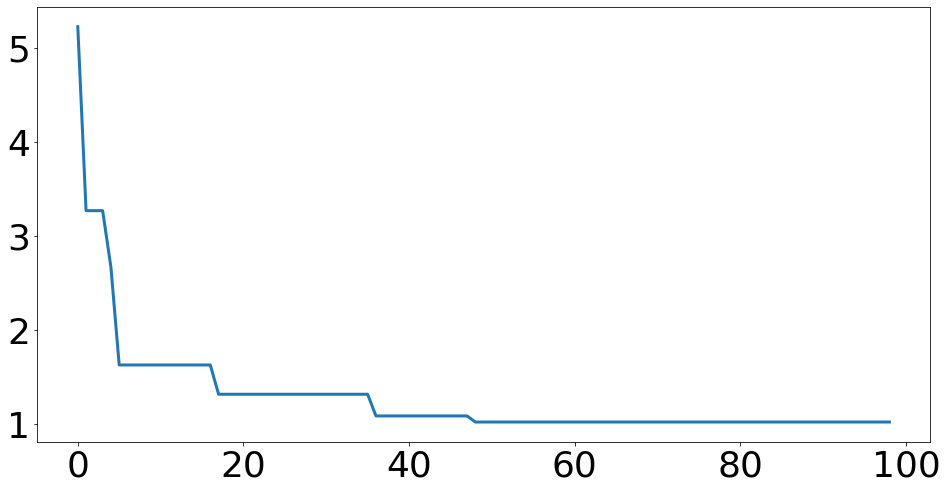

In [50]:
_ = plt.plot([np.min(List_of_loss[:i]) for i in range(1, len(List_of_loss))])

# Гаусовский процесс

# HOAG

In [183]:
model = Neural(input_dim=n, output_dim=1, hidden_dim=1)
model.random_h_init()

optimazer_theta = optim.Adam(model.parameters(), lr=0.01)
optimazer_h = optim.SGD(model.list_of_h, lr=0.01)

List_of_h = []
List_of_loss = []

for epoch in tqdm(range(200)):
    for ep in range(200):
        generator = DataLoader(train_data, batch_size=64, shuffle=True)
        for batch_x, batch_y in generator:
            model.zero_grad()
            loss = -model.margin_log_likelihood(batch_x, batch_y)
            loss.backward()
            optimazer_theta.step()
    
    model.zero_grad()
    model.h_zero_grad()
    hess = hessian(-model.margin_log_likelihood(X_valid, Y_valid), model.parameters())
    model.h_zero_grad()
    model.zero_grad()
    grad = gradient(model.loss(X_valid, Y_valid), model.parameters())

    lambd = torch.inverse(hess)@grad

    model.h_zero_grad()
    model.zero_grad()
    grad = gradient(-model.margin_log_likelihood(X_valid, Y_valid), model.parameters(), create_graph=True)

    mat = torch.cat([gradient(gr, model.list_of_h, retain_graph=True).view([-1, 1]) for gr in grad], dim = 1)

    full_grad = -mat.transpose(0,1)@lambd

    model.zero_grad()
    model.h_zero_grad()
    model.h_set_grad(full_grad)

    optimazer_h.step()
    List_of_h.append(h_to_numpy(model))
    List_of_loss.append(model.loss(X_valid, Y_valid).item())

    

List_of_h = np.array(List_of_h)
List_of_loss = np.array(List_of_loss)

100%|██████████| 200/200 [05:19<00:00,  1.53s/it]


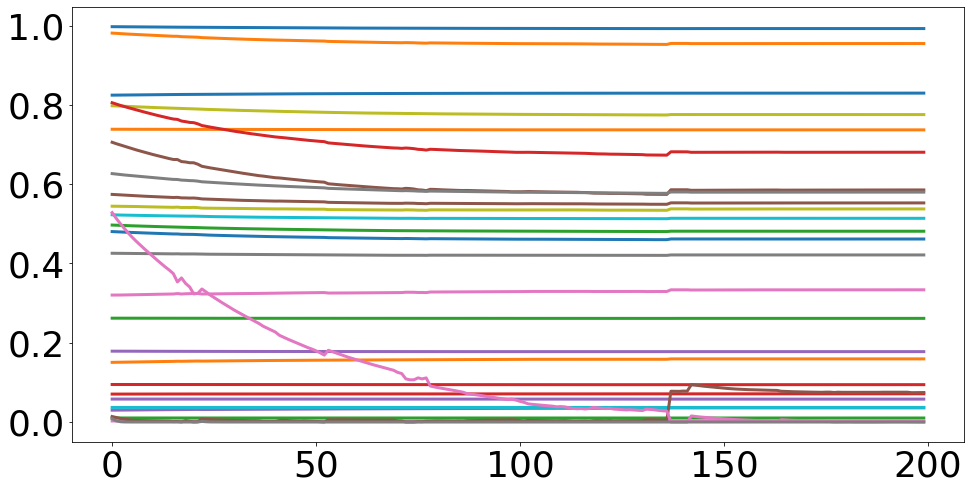

In [184]:
_ = plt.plot(List_of_h**2)

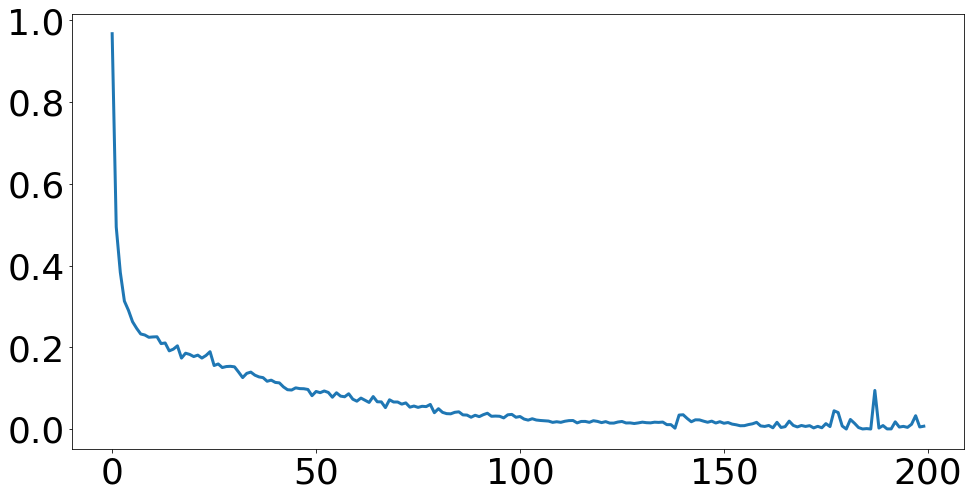

In [185]:
_ = plt.plot(List_of_loss)